# 2.4

In [21]:
import pandas
from cardio_datasets import all_features_dataset_dropped_samples
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Split data into test and validation sets

In [22]:
def create_X_y_from_data_frame(data_frame: pandas.DataFrame, target_column: str):
    """Takes a pandas DataFrame and string of target column and returns X, y"""
    return data_frame.drop(columns=[target_column]), data_frame[target_column]

In [23]:
X, y = create_X_y_from_data_frame(all_features_dataset_dropped_samples, 'cardio')
X_train_all, X_test_unseen, y_train_all, y_test_unseen = train_test_split(X,y,test_size=0.3,random_state=42)
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(X_train_all,y_train_all,test_size=0.3,random_state=42)

## Search and score parameters

In [24]:
def grid_search_hyper_parameters(X, y, unfitted_model, parameter_grid: dict, scoring_method: str):
    """Retruns a fitted model and a pandas.DataFrame of GridSearchCV.cv_results"""
    model = GridSearchCV(estimator=unfitted_model,param_grid=parameter_grid,return_train_score=False,scoring=scoring_method,cv=5)
    model.fit(X, y)
    return model, pandas.DataFrame(model.cv_results_)

In [25]:
def select_search_parameters_and_scores(results_data_frame:pandas.DataFrame, parameter_grid:dict):
    """Returns a selection of parameters and scores from a GridSearchCV.cv_results_ data frame using the keys from a parameter grid"""
    columns = ['param_' + key for key in list(parameter_grid.keys())] + ['mean_test_score', 'std_test_score']
    return results_data_frame[columns].sort_values('mean_test_score', ascending=False).reset_index(drop=True)

In [26]:
def search_hyper_parameters(X, y, unfitted_model, parameter_grid:dict, scoring_method:str):
    """Returns a fitted model, a selection of parameters and scores of GridSearchCV.cv_results_, raw GridSearchCV.cv_results_"""
    model, scores = grid_search_hyper_parameters(X, y, unfitted_model, parameter_grid, scoring_method)
    return model, select_search_parameters_and_scores(scores, parameter_grid), scores

In [27]:
pipeline_logistic_regression = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "LogisticRegression",
            LogisticRegression(
                solver="saga", multi_class="ovr", max_iter=10000, penalty="elasticnet"
            ),
        ),
    ]
)
pipeline_logistic_regression_parameter_grid = {"LogisticRegression__l1_ratio": [0, 1]}

(
    logistic_regression_model,
    logistic_regression_parameters_and_score,
    logistic_regression_score_raw,
) = search_hyper_parameters(
    X_train_eval,
    y_train_eval,
    pipeline_logistic_regression,
    pipeline_logistic_regression_parameter_grid,
    'recall'
)
logistic_regression_parameters_and_score

,param_LogisticRegression__l1_ratio,mean_test_score,std_test_score
0,1,0.650108,0.010040
1,0,0.649925,0.009978


TODO write about https://www.youtube.com/watch?v=HdlDYng8g9s

## Show classification score metrics

In [28]:
def show_classification_evaluation_metrics(model, X_test, y_test, display_labels=['True', 'False']):
    """Prints classification report and plots confusion matrix"""
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=display_labels).plot()

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      7183
           1       0.76      0.64      0.70      7034

    accuracy                           0.72     14217
   macro avg       0.73      0.72      0.72     14217
weighted avg       0.73      0.72      0.72     14217



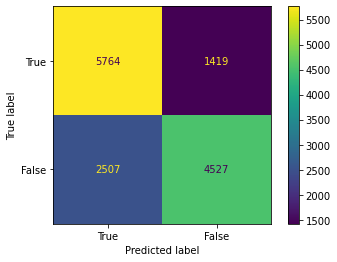

In [29]:
show_classification_evaluation_metrics(logistic_regression_model, X_test_eval, y_test_eval)

## Complete function

In [30]:
def search_score_and_evalute_parameters(X_train, X_test, y_train, y_test, model, model_parameter_grid:dict, scoring_method:str):
    """Searches, scores and prints evaluation of a model and it's parameters then returns the model"""
    (
    fitted_model,
    model_parameters_and_score,
    _model_parameters_and_score_raw
    ) = search_hyper_parameters(
        X_train,
        y_train,
        model,
        model_parameter_grid,
        scoring_method
    )
    print(model_parameters_and_score)
    show_classification_evaluation_metrics(fitted_model, X_test, y_test)
    return fitted_model

  param_LogisticRegression__l1_ratio  mean_test_score  std_test_score
0                                  1         0.650108        0.010040
1                                  0         0.649925        0.009978
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      7183
           1       0.76      0.64      0.70      7034

    accuracy                           0.72     14217
   macro avg       0.73      0.72      0.72     14217
weighted avg       0.73      0.72      0.72     14217



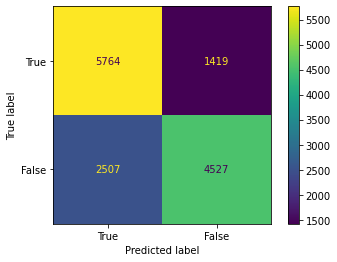

In [31]:
logistic_regression_model = search_score_and_evalute_parameters(
    X_train_eval,
    X_test_eval,
    y_train_eval,
    y_test_eval,
    pipeline_logistic_regression,
    pipeline_logistic_regression_parameter_grid,
    "recall",
)

## Test on unseen data

              precision    recall  f1-score   support

           0       0.70      0.80      0.75     10251
           1       0.76      0.65      0.70     10059

    accuracy                           0.73     20310
   macro avg       0.73      0.73      0.73     20310
weighted avg       0.73      0.73      0.73     20310



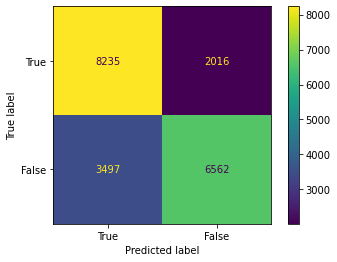

In [32]:
show_classification_evaluation_metrics(logistic_regression_model, X_test_unseen, y_test_unseen)